<a href="https://colab.research.google.com/github/PederRonning/SOK3022/blob/main/CPI_ARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%pip install pyjstat

In [19]:
import pandas as pd
from pyjstat import pyjstat
import requests
import matplotlib.pyplot as plt
import numpy as np

# KPI
POST_URL = 'https://data.ssb.no/api/v0/no/table/08981'

payload = {
  "query": [
    {
      "code": "Maaned",
      "selection": {
        "filter": "item",
        "values": [
          "01",
          "02",
          "03",
          "04",
          "05",
          "06",
          "07",
          "08",
          "09",
          "10",
          "11",
          "12"
        ]
      }
    }
  ],
  "response": {
    "format": "json-stat2"
  }
}

resultat = requests.post(POST_URL, json = payload)
# Resultat gir bare http statuskode - 200 hvis OK. Body ligger i resultat.text
print(resultat)

dataset = pyjstat.Dataset.read(resultat.text)
df = dataset.write('dataframe')
#df = df[['år', 'value']]
#df.set_index('år', inplace=True)

<Response [200]>


In [20]:
#df['år'] = pd.to_datetime(df['år'], format='%Y')
# Map Norwegian month names to month numbers
month_mapping = {
    'Januar': 1,
    'Februar': 2,
    'Mars': 3,
    'April': 4,
    'Mai': 5,
    'Juni': 6,
    'Juli': 7,
    'August': 8,
    'September': 9,
    'Oktober': 10,
    'November': 11,
    'Desember': 12
}
df['måned'] = df['måned'].map(month_mapping)  # Apply mapping

# remove NA
df = df.dropna()

In [21]:
df

,måned,statistikkvariabel,år,value
1,1,Konsumprisindeks (2015=100),1921,5.7
2,1,Konsumprisindeks (2015=100),1922,4.6
3,1,Konsumprisindeks (2015=100),1923,4.0
4,1,Konsumprisindeks (2015=100),1924,4.1
5,1,Konsumprisindeks (2015=100),1925,4.7
...,...,...,...,...
1266,12,Konsumprisindeks (2015=100),2020,112.9
1267,12,Konsumprisindeks (2015=100),2021,118.9
1268,12,Konsumprisindeks (2015=100),2022,125.9
1269,12,Konsumprisindeks (2015=100),2023,131.9


In [22]:
from pandas.tseries.offsets import MonthEnd

# rename år to year
df.rename(columns={'år': 'year'}, inplace=True)
# rename måned til month
df.rename(columns={'måned': 'month'}, inplace=True)

df['time'] = pd.to_datetime(df[['year', 'month']].assign(DAY=1)) + MonthEnd(1)
df = df.sort_values(by=['time'])

In [23]:
df = df[['time', 'value']]

# set date column as index
df.set_index('time', inplace=True)

<Axes: xlabel='time'>

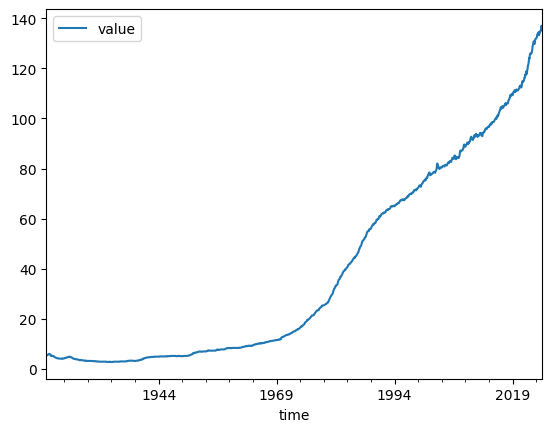

In [24]:
df.plot()

In [25]:
df['value'] = df['value'].pct_change() * 100
df = df.dropna()

In [26]:
df.describe()

,value
count,1261.000000
mean,0.265825
std,0.953099
min,-5.263158
25%,0.000000
50%,0.000000
75%,0.571429
max,8.108108


In [27]:
df_2010 = df[df.index > '2005-01-01']

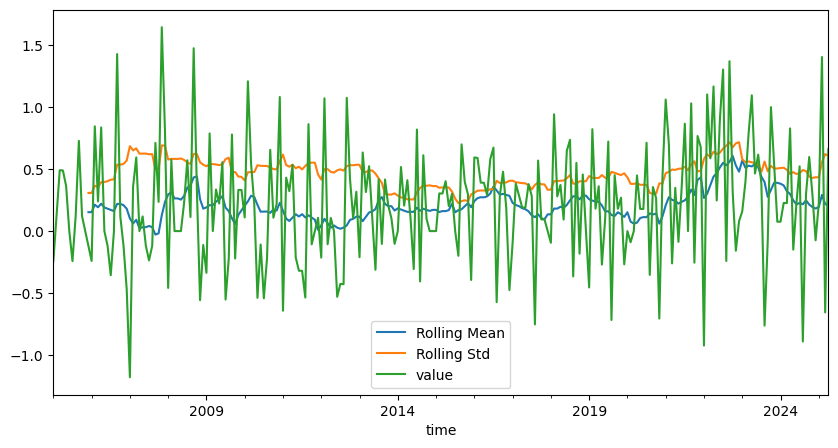

In [28]:
time_series = df_2010['value']
time_series.rolling(window=12).mean().plot(label='Rolling Mean')
time_series.rolling(window=12).std().plot(label='Rolling Std')
time_series.plot(figsize=(10,5))
plt.legend()
plt.show()

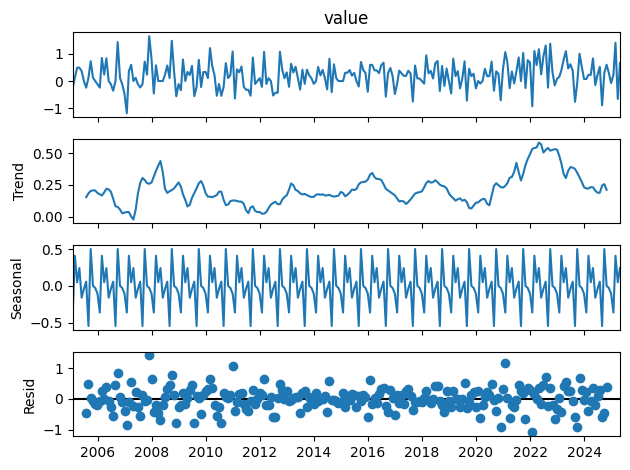

In [29]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomp = seasonal_decompose(time_series)
fig = decomp.plot()

In [30]:
# check if inflation series is stationary
from statsmodels.tsa.stattools import adfuller

# ADF test
def adf_test(time_series):
    result = adfuller(time_series, autolag='AIC')
    print('1. ADF: ', result[0])
    print('2. P-value: ', result[1])
    print('3. Num of Lags: ', result[2])
    print('4. Num of Observations: ', result[3])
    print('5. Critial Values:')
    for key, value in result[4].items():
        print('\t', key, ': ', value)

    if result[1] <= 0.05:
        print('\nStrong evidence against the null hypothesis (H0), reject the null hypothesis. Data has no unit root and is stationary.')
    else:
        print('\nWeak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary.')

# run function
adf_test(df['value'])

1. ADF:  -6.300063689065199
2. P-value:  3.4295286540646164e-08
3. Num of Lags:  17
4. Num of Observations:  1243
5. Critial Values:
	 1% :  -3.435621806786881
	 5% :  -2.8638680226791444
	 10% :  -2.5680094689100477

Strong evidence against the null hypothesis (H0), reject the null hypothesis. Data has no unit root and is stationary.


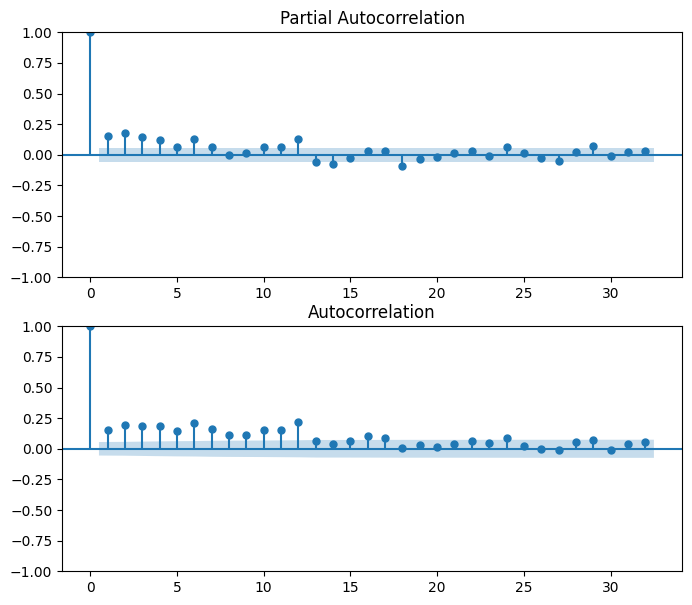

In [32]:
# plotting ACF and PACF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig = plt.figure(figsize=(8,7))
ax1 = fig.add_subplot(2,1,1)
fig = plot_pacf(df, ax=ax1)
ax2 = fig.add_subplot(2,1,2)
fig = plot_acf(df, ax=ax2)
plt.show()

In [48]:
# p=1, d=0, q=0
from statsmodels.tsa.arima.model import ARIMA

# fitting the model
model = ARIMA(df_2010['value'], order=(1,0,0), freq='M')
model_fit = model.fit()
model_fit.summary()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:595: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = to_offset(freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                  244
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -163.320
Date:                Mon, 12 May 2025   AIC                            332.639
Time:                        17:47:47   BIC                            343.131
Sample:                    01-31-2005   HQIC                           336.865
                         - 04-30-2025                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2147      0.028      7.704      0.000       0.160       0.269
ar.L1         -0.0933      0.064     -1.466      0.143      -0.218       0.031
sigma2         0.2233      0.019     11.700      0.000       0.186       0.261
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 1.95
Prob(Q):                              0.95   Prob(JB):                         0.38
Heteroskedasticity (H):               1.00   Skew:                             0.17
Prob(H) (two-sided):                  0.99   Kurtosis:                         3.28
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [49]:
forecast = model_fit.predict(start=0, end=len(df_2010) - 1, typ='levels', dynamic=False)

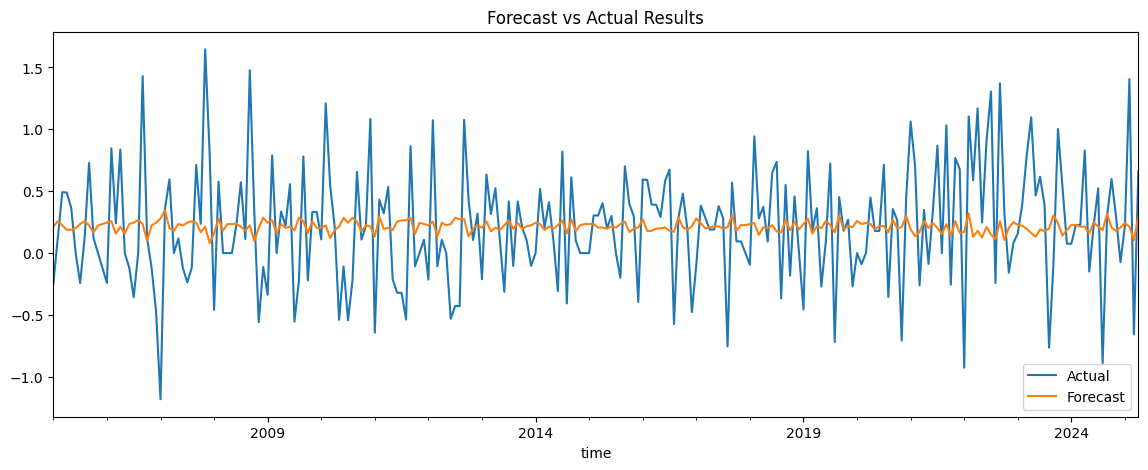

In [51]:
# plot results
df_2010['value'].plot(legend=True, label='Actual', figsize=(14,5))
forecast.plot(legend=True, label='Forecast')
plt.title('Forecast vs Actual Results')
plt.show()

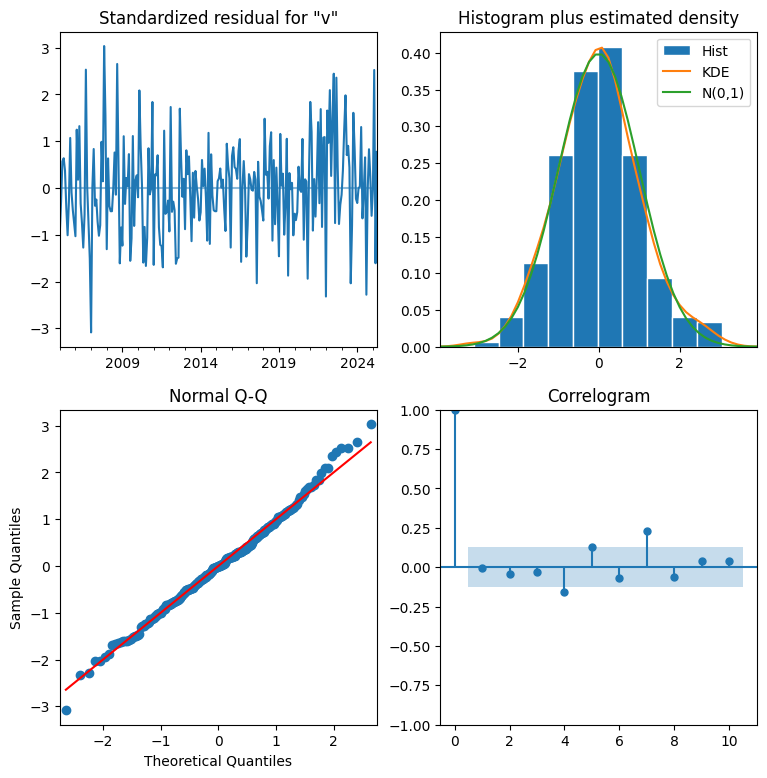

In [52]:
# diagnostic plots for standardized residuals of one endogenous variable
model_fit.plot_diagnostics(figsize=(9,9))
plt.show()

In [55]:
# root mean squared error
from sklearn.metrics import mean_squared_error
rmse = mean_squared_error(forecast, df_2010['value'])
rmse

0.22331021819037974

In [56]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(forecast, df_2010['value'])
mae

0.36813629523864577

In [61]:
# predict values
forecast_future = model_fit.predict(start=0, end=len(df_2010) + 4, dynamic=False)

In [65]:
# display forecasted values
forecast_future.tail()

,predicted_mean
2025-05-31,0.173057
2025-06-30,0.218600
2025-07-31,0.214351
2025-08-31,0.214748
2025-09-30,0.214711


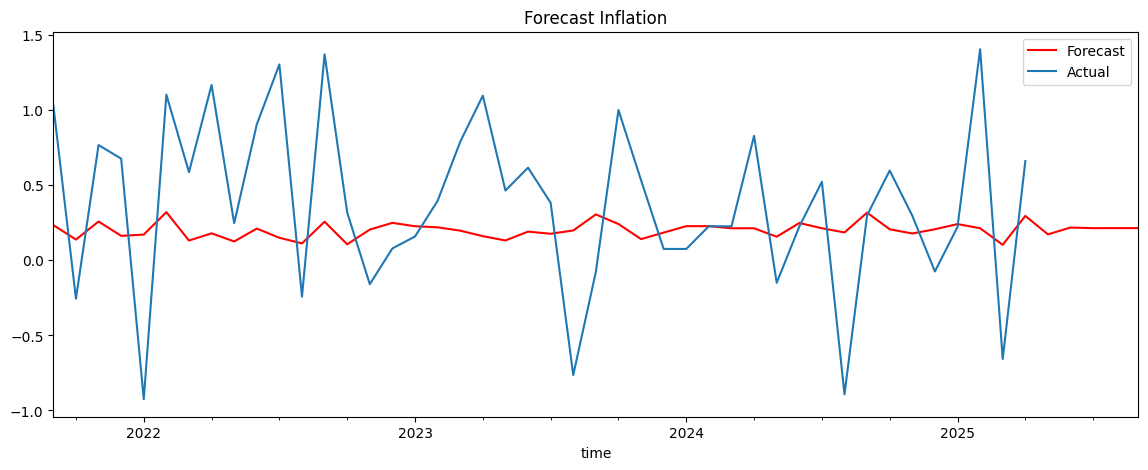

In [72]:
# final plot
forecast_future.iloc[200:].plot(legend=True, label='Forecast', figsize=(14,5), color='red')
df_2010['value'].iloc[200:].plot(legend=True, label='Actual')
plt.title('Forecast Inflation')
plt.show()